In [1]:
#Dependecies
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import shutil
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

In [2]:
#Kelas Kendaraan
Kendaraan = os.path.join('/content/drive/My Drive/Dicoding/Submission/Submission_3/Dataset/train')
print(os.listdir(Kendaraan))

['airplanes', 'ship', 'cars']


Sumber Data : https://www.kaggle.com/abtabm/multiclassimagedatasetairplanecar

In [3]:
#Menunjukkan Size Gambar
total = 0
Jenis = os.listdir(Kendaraan)

for i in Jenis:
  dir = os.path.join(Kendaraan, i)
  y = len(os.listdir(dir))
  print(i + ':', y)
  total = total + y

  image_name = os.listdir(dir)
  for j in range(5):
    image_path = os.path.join(dir, image_name[j])
    image = Image.open(image_path)
    print('#', image.size)
  print('_________________')

print('\nTotal :', total)

airplanes: 1000
# (1200, 1200)
# (1200, 1200)
# (1200, 1200)
# (1200, 1200)
# (1200, 1200)
_________________
ship: 1000
# (210, 122)
# (210, 151)
# (210, 158)
# (210, 131)
# (210, 140)
_________________
cars: 1000
# (640, 480)
# (220, 165)
# (600, 480)
# (3870, 2070)
# (413, 290)
_________________

Total : 3000


Size Berbeda-beda


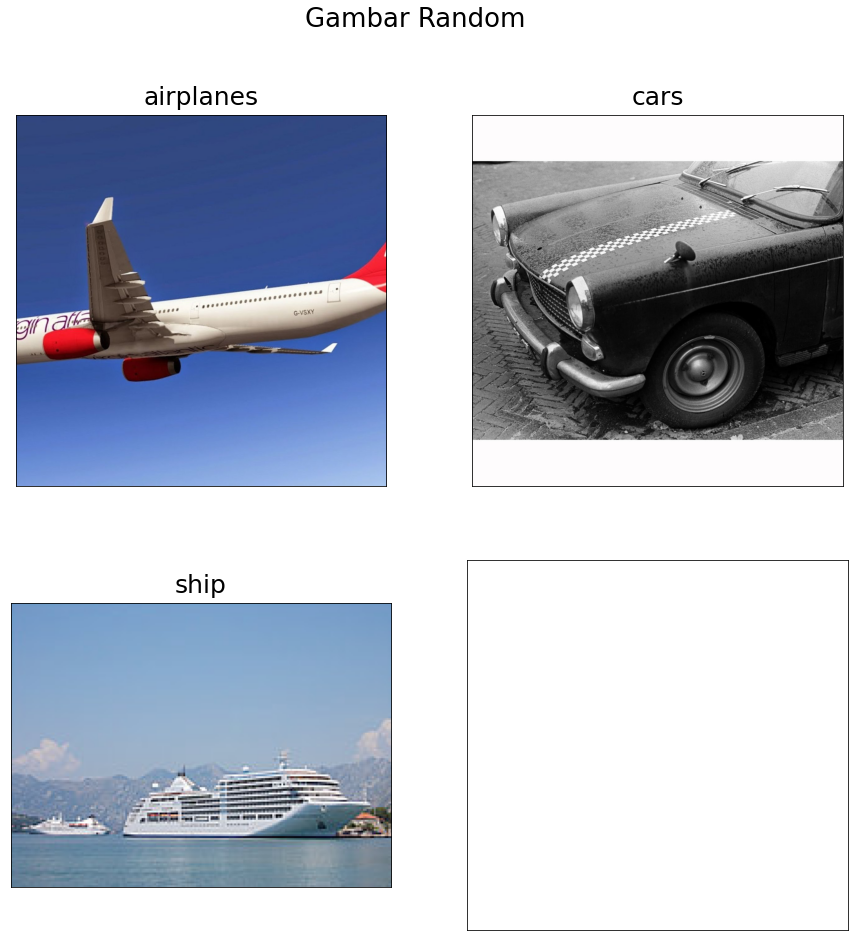

In [4]:
#Menunjukkan Gambar Secara Acak
fig, ax = plt.subplots(2,2, figsize=(15,15))
fig.suptitle('Gambar Random', fontsize = 26)
Kendaraan_Urut = sorted(Jenis)
Kendaraan_id = 0

for i in range(2):
  for j in range(2):
    try:
      Kendaraan_terpilih = Kendaraan_Urut[Kendaraan_id]
      Kendaraan_id += 1
    except:
      break
    if Kendaraan_terpilih == '.TEMP':
      continue
    Gambar_Kendaraan_terpilih = os.listdir(os.path.join(Kendaraan,Kendaraan_terpilih))
    Gambar_Kendaraan_random = np.random.choice(Gambar_Kendaraan_terpilih)
    image = plt.imread(os.path.join(Kendaraan, Kendaraan_terpilih,Gambar_Kendaraan_random))
    ax[i][j].imshow(image)
    ax[i][j].set_title(Kendaraan_terpilih, pad = 10, fontsize = 25)
plt.setp(ax, xticks=[], yticks=[])
plt.show()

In [5]:
#Augmentasi Gambar
Datagen_train = ImageDataGenerator(
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rotation_range = 50,
    rescale = 1/255,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range=0.2,
    fill_mode = 'nearest',
    validation_split = 0.2
)

In [6]:
#Mensplit Dataset
batch_size = 256

Data_train = Datagen_train.flow_from_directory(
    Kendaraan,
    target_size = (100,100),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')
Data_val = Datagen_train.flow_from_directory(
    Kendaraan,
    target_size = (100,100),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation')

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [7]:
#Membuat Model CNN
Model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

Model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         2

In [8]:
#Optimizer
Optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8)

#Callback dengan Target 92%
class CallbackIni(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("\Akurasi telah diatas 92%")
      self.model.stop_training = True

callbacks = CallbackIni()

In [10]:
#Train Model
history = Model.fit(Data_train, 
                    epochs = 40, 
                    steps_per_epoch = Data_train.samples // batch_size,
                    validation_data = Data_val, 
                    validation_steps = Data_val.samples // batch_size,
                    verbose = 2,
                    callbacks = [callbacks])

Epoch 1/40
9/9 - 972s - loss: 1.0836 - accuracy: 0.3661 - val_loss: 0.9969 - val_accuracy: 0.5293
Epoch 2/40
9/9 - 42s - loss: 0.9899 - accuracy: 0.4776 - val_loss: 0.8831 - val_accuracy: 0.5605
Epoch 3/40
9/9 - 43s - loss: 0.9110 - accuracy: 0.5219 - val_loss: 0.8502 - val_accuracy: 0.5547
Epoch 4/40
9/9 - 42s - loss: 0.8793 - accuracy: 0.5466 - val_loss: 0.8477 - val_accuracy: 0.6113
Epoch 5/40
9/9 - 42s - loss: 0.8856 - accuracy: 0.5532 - val_loss: 0.8635 - val_accuracy: 0.5684
Epoch 6/40
9/9 - 43s - loss: 0.8317 - accuracy: 0.6068 - val_loss: 0.7591 - val_accuracy: 0.6504
Epoch 7/40
9/9 - 43s - loss: 0.7828 - accuracy: 0.6241 - val_loss: 0.7677 - val_accuracy: 0.6523
Epoch 8/40
9/9 - 42s - loss: 0.7433 - accuracy: 0.6451 - val_loss: 0.7507 - val_accuracy: 0.6504
Epoch 9/40
9/9 - 41s - loss: 0.7369 - accuracy: 0.6768 - val_loss: 0.7214 - val_accuracy: 0.6797
Epoch 10/40
9/9 - 43s - loss: 0.7092 - accuracy: 0.6842 - val_loss: 0.7141 - val_accuracy: 0.6816
Epoch 11/40
9/9 - 43s - loss

Akurasi Train Dataset 0.8862, Akurasi Val Dataset 0.8750

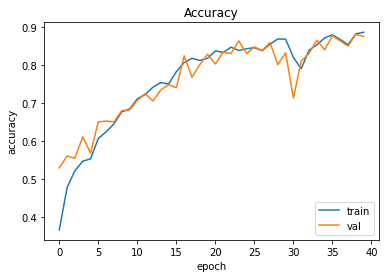

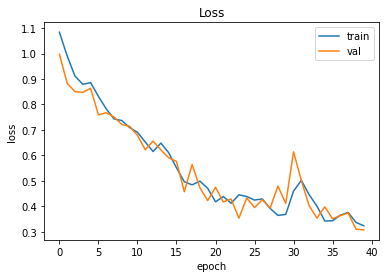

In [12]:
#Plot Progress dari Train Model

#Akurasi
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

#Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [11]:
#convert ke TF-LITE
converter = tf.lite.TFLiteConverter.from_keras_model(Model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpm2k8qto6/assets
